# 6-2,训练模型的3种方法

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

下面以minist数据集的多分类模型的训练为例，演示这3种训练模型的风格。

其中类形式训练循环我们同时演示torchkeras.KerasModel和torchkeras.LightModel两种示范。


In [1]:
import torch 
import torchkeras
print("torch.__version__ = ", torch.__version__)
print("torchkeras.__version__ = ", torchkeras.__version__) 

torch.__version__ =  2.0.1
torchkeras.__version__ =  3.2.3


```
torch.__version__ =  1.10.0
torchkeras.__version__ =  3.2.3
```

### 〇，准备数据

In [2]:
import torch 
from torch import nn 

import torchvision 
from torchvision import transforms


In [9]:
from torch.utils.data import random_split



transform = transforms.Compose([transforms.ToTensor()])

ds_train = torchvision.datasets.MNIST(root="./data/minist/",train=True,download=True,transform=transform)
ds_val = torchvision.datasets.MNIST(root="./data/minist/",train=False,download=True,transform=transform)
ds_train, _ = random_split(ds_train, [10, len(ds_train)-10])
ds_val, _ = random_split(ds_val, [5, len(ds_val)-5])


dl_train =  torch.utils.data.DataLoader(ds_train, batch_size=1, shuffle=True, num_workers=0)
dl_val =  torch.utils.data.DataLoader(ds_val, batch_size=1, shuffle=False, num_workers=0)

print(len(ds_train))
print(len(ds_val))

10
5


```
60000
10000
```

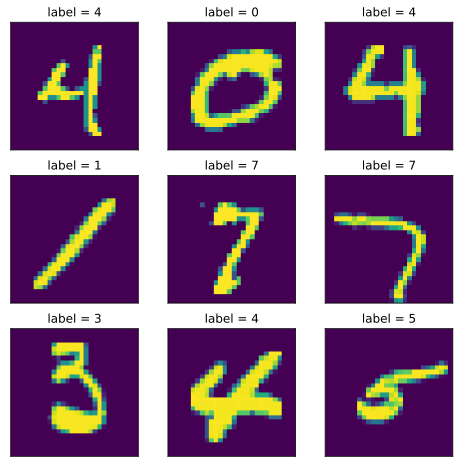

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = torch.squeeze(img)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

![](./data/6-2-minist.png)

### 一，脚本风格

脚本风格的训练循环最为常见。

In [5]:
net = nn.Sequential()
net.add_module("conv1",nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3))
net.add_module("pool1",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("conv2",nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5))
net.add_module("pool2",nn.MaxPool2d(kernel_size = 2,stride = 2))
net.add_module("dropout",nn.Dropout2d(p = 0.1))
net.add_module("adaptive_pool",nn.AdaptiveMaxPool2d((1,1)))
net.add_module("flatten",nn.Flatten())
net.add_module("linear1",nn.Linear(64,32))
net.add_module("relu",nn.ReLU())
net.add_module("linear2",nn.Linear(32,10))

print(net)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)


```
Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)
```

In [13]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy
from torchmetrics import Accuracy
#注：多分类使用torchmetrics中的评估指标，二分类使用torchkeras.metrics中的评估指标

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")
    

loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(net.parameters(),lr = 0.01)   
metrics_dict = {"acc":Accuracy(task='multiclass', num_classes=10)}

epochs = 1 
ckpt_path='checkpoint.pt'

#early_stopping相关设置
monitor="val_acc"
patience=1
mode="max"

history = {}

for epoch in range(1, epochs+1):
    printlog("Epoch {0} / {1}".format(epoch, epochs))

    # 1，train -------------------------------------------------  
    net.train()
    
    total_loss,step = 0,0
    
    loop = tqdm(enumerate(dl_train), total =len(dl_train))
    train_metrics_dict = deepcopy(metrics_dict) 
    
    for i, batch in loop: 
        
        features,labels = batch
        #forward
        preds = net(features)
        loss = loss_fn(preds,labels)
        
        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        #metrics
        step_metrics = {"train_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in train_metrics_dict.items()}
        
        step_log = dict({"train_loss":loss.item()},**step_metrics)

        total_loss += loss.item()
        
        step+=1
        if i!=len(dl_train)-1:
            loop.set_postfix(**step_log)
        else:
            epoch_loss = total_loss/step
            epoch_metrics = {"train_"+name:metric_fn.compute().item() 
                             for name,metric_fn in train_metrics_dict.items()}
            epoch_log = dict({"train_loss":epoch_loss},**epoch_metrics)
            loop.set_postfix(**epoch_log)

            for name,metric_fn in train_metrics_dict.items():
                metric_fn.reset()
                
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]
        

    # 2，validate -------------------------------------------------
    net.eval()
    
    total_loss,step = 0,0
    loop = tqdm(enumerate(dl_val), total =len(dl_val))
    
    val_metrics_dict = deepcopy(metrics_dict) 
    
    with torch.no_grad():
        for i, batch in loop: 

            features,labels = batch
            
            #forward
            preds = net(features)
            loss = loss_fn(preds,labels)

            #metrics
            step_metrics = {"val_"+name:metric_fn(preds, labels).item() 
                            for name,metric_fn in val_metrics_dict.items()}

            step_log = dict({"val_loss":loss.item()},**step_metrics)

            total_loss += loss.item()
            step+=1
            if i!=len(dl_val)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = (total_loss/step)
                epoch_metrics = {"val_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in val_metrics_dict.items()}
                epoch_log = dict({"val_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in val_metrics_dict.items():
                    metric_fn.reset()
                    
    epoch_log["epoch"] = epoch           
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]

    # 3，early-stopping -------------------------------------------------
    arr_scores = history[monitor]
    best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
    if best_score_idx==len(arr_scores)-1:
        torch.save(net.state_dict(),ckpt_path)
        print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
             arr_scores[best_score_idx]),file=sys.stderr)
    if len(arr_scores)-best_score_idx>patience:
        print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
            monitor,patience),file=sys.stderr)
        break 
    net.load_state_dict(torch.load(ckpt_path))
    
dfhistory = pd.DataFrame(history)



================================================================================2023-05-23 16:03:32
Epoch 1 / 1



100%|██████████| 5/5 [00:00<00:00, 120.84it/s, val_acc=0.2, val_loss=2.76]
<<<<<< reach best val_acc : 0.20000000298023224 >>>>>>


```
================================================================================2022-07-17 19:21:50
Epoch 17 / 20


100%|██████████| 469/469 [01:01<00:00,  7.67it/s, train_acc=0.985, train_loss=0.06]   
100%|██████████| 79/79 [00:07<00:00, 10.45it/s, val_acc=0.985, val_loss=0.0659] 

================================================================================2022-07-17 19:22:59
Epoch 18 / 20


<<<<<< reach best val_acc : 0.9851999878883362 >>>>>>
100%|██████████| 469/469 [00:57<00:00,  8.14it/s, train_acc=0.983, train_loss=0.0692]
100%|██████████| 79/79 [00:07<00:00, 10.89it/s, val_acc=0.984, val_loss=0.0849]

================================================================================2022-07-17 19:24:04
Epoch 19 / 20


100%|██████████| 469/469 [01:08<00:00,  6.82it/s, train_acc=0.984, train_loss=0.0679] 
100%|██████████| 79/79 [00:06<00:00, 11.39it/s, val_acc=0.983, val_loss=0.087]  

================================================================================2022-07-17 19:25:20
Epoch 20 / 20


100%|██████████| 469/469 [00:57<00:00,  8.14it/s, train_acc=0.986, train_loss=0.0553] 
100%|██████████| 79/79 [00:06<00:00, 11.35it/s, val_acc=0.983, val_loss=0.0813]
```

### 二，函数风格

该风格在脚本形式上做了进一步的函数封装。

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
net = Net()
print(net)

Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)


```
Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten()
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)
```

In [15]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")

class StepRunner:
    def __init__(self, net, loss_fn,
                 stage = "train", metrics_dict = None, 
                 optimizer = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer = optimizer
            
    def step(self, features, labels):
        #loss
        preds = self.net(features)
        loss = self.loss_fn(preds,labels)
        
        #backward()
        if self.optimizer is not None and self.stage=="train": 
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
        #metrics
        step_metrics = {self.stage+"_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        return loss.item(),step_metrics
    
    def train_step(self,features,labels):
        self.net.train() #训练模式, dropout层发生作用
        return self.step(features,labels)
    
    @torch.no_grad()
    def eval_step(self,features,labels):
        self.net.eval() #预测模式, dropout层不发生作用
        return self.step(features,labels)
    
    def __call__(self,features,labels):
        if self.stage=="train":
            return self.train_step(features,labels) 
        else:
            return self.eval_step(features,labels)
        
class EpochRunner:
    def __init__(self,steprunner):
        self.steprunner = steprunner
        self.stage = steprunner.stage
        
    def __call__(self,dataloader):
        total_loss,step = 0,0
        loop = tqdm(enumerate(dataloader), total =len(dataloader))
        for i, batch in loop: 
            loss, step_metrics = self.steprunner(*batch)
            step_log = dict({self.stage+"_loss":loss},**step_metrics)
            total_loss += loss
            step+=1
            if i!=len(dataloader)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss/step
                epoch_metrics = {self.stage+"_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in self.steprunner.metrics_dict.items()}
                epoch_log = dict({self.stage+"_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in self.steprunner.metrics_dict.items():
                    metric_fn.reset()
        return epoch_log


def train_model(net, optimizer, loss_fn, metrics_dict, 
                train_data, val_data=None, 
                epochs=10, ckpt_path='checkpoint.pt',
                patience=5, monitor="val_loss", mode="min"):
    
    history = {}

    for epoch in range(1, epochs+1):
        printlog("Epoch {0} / {1}".format(epoch, epochs))

        # 1，train -------------------------------------------------  
        train_step_runner = StepRunner(net = net,stage="train",
                loss_fn = loss_fn,metrics_dict=deepcopy(metrics_dict),
                optimizer = optimizer)
        train_epoch_runner = EpochRunner(train_step_runner)
        train_metrics = train_epoch_runner(train_data)

        for name, metric in train_metrics.items():
            history[name] = history.get(name, []) + [metric]

        # 2，validate -------------------------------------------------
        if val_data:
            val_step_runner = StepRunner(net = net,stage="val",
                loss_fn = loss_fn,metrics_dict=deepcopy(metrics_dict))
            val_epoch_runner = EpochRunner(val_step_runner)
            with torch.no_grad():
                val_metrics = val_epoch_runner(val_data)
            val_metrics["epoch"] = epoch
            for name, metric in val_metrics.items():
                history[name] = history.get(name, []) + [metric]

        # 3，early-stopping -------------------------------------------------
        arr_scores = history[monitor]
        best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
        if best_score_idx==len(arr_scores)-1:
            torch.save(net.state_dict(),ckpt_path)
            print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                 arr_scores[best_score_idx]),file=sys.stderr)
        if len(arr_scores)-best_score_idx>patience:
            print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                monitor,patience),file=sys.stderr)
            break 
        net.load_state_dict(torch.load(ckpt_path))

    return pd.DataFrame(history)


In [16]:
from torchmetrics import Accuracy
loss_fn = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(net.parameters(),lr = 0.01)   
metrics_dict = {"acc":Accuracy()}

dfhistory = train_model(net,
    optimizer,
    loss_fn,
    metrics_dict,
    train_data = dl_train,
    val_data= dl_val,
    epochs=10,
    patience=3,
    monitor="val_acc", 
    mode="max")


TypeError: __new__() missing 1 required positional argument: 'task'

```
================================================================================2022-07-17 19:27:50
Epoch 1 / 10

100%|██████████| 469/469 [01:00<00:00,  7.71it/s, train_acc=0.905, train_loss=0.296] 
100%|██████████| 79/79 [00:07<00:00, 11.18it/s, val_acc=0.96, val_loss=0.129]  

================================================================================2022-07-17 19:28:58
Epoch 2 / 10


<<<<<< reach best val_acc : 0.9603000283241272 >>>>>>
100%|██████████| 469/469 [00:57<00:00,  8.19it/s, train_acc=0.966, train_loss=0.115] 
100%|██████████| 79/79 [00:06<00:00, 11.55it/s, val_acc=0.982, val_loss=0.0639]

================================================================================2022-07-17 19:30:02
Epoch 3 / 10


<<<<<< reach best val_acc : 0.9815999865531921 >>>>>>
100%|██████████| 469/469 [01:00<00:00,  7.71it/s, train_acc=0.971, train_loss=0.0982]
100%|██████████| 79/79 [00:07<00:00, 10.21it/s, val_acc=0.976, val_loss=0.0831] 

================================================================================2022-07-17 19:31:11
Epoch 4 / 10


100%|██████████| 469/469 [00:58<00:00,  8.06it/s, train_acc=0.972, train_loss=0.0932]
100%|██████████| 79/79 [00:06<00:00, 11.32it/s, val_acc=0.978, val_loss=0.0786]

================================================================================2022-07-17 19:32:17
Epoch 5 / 10


100%|██████████| 469/469 [00:57<00:00,  8.21it/s, train_acc=0.971, train_loss=0.0992]
100%|██████████| 79/79 [00:07<00:00, 11.04it/s, val_acc=0.978, val_loss=0.0774]
<<<<<< val_acc without improvement in 3 epoch, early stopping >>>>>>
```

### 三，类风格 torchkeras.KerasModel

此处使用torchkeras.KerasModel高层次API接口中的fit方法训练模型。

使用该形式训练模型非常简洁明了。



In [17]:
from torchkeras import KerasModel 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
net = Net() 

print(net)

Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)


```
Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)
```

In [18]:
from torchmetrics import Accuracy

model = KerasModel(net,
                   loss_fn=nn.CrossEntropyLoss(),
                   metrics_dict = {"acc":Accuracy()},
                   optimizer = torch.optim.Adam(net.parameters(),lr = 0.01)  )

model.fit(
    train_data = dl_train,
    val_data= dl_val,
    epochs=10,
    patience=3,
    monitor="val_acc", 
    mode="max")


TypeError: __new__() missing 1 required positional argument: 'task'

```
================================================================================2022-07-17 21:01:18
Epoch 1 / 10

100%|██████████| 469/469 [00:58<00:00,  7.98it/s, train_acc=0.906, train_loss=0.291] 
100%|██████████| 79/79 [00:07<00:00, 10.60it/s, val_acc=0.974, val_loss=0.0773]
<<<<<< reach best val_acc : 0.9739999771118164 >>>>>>

================================================================================2022-07-17 21:02:24
Epoch 2 / 10

100%|██████████| 469/469 [01:00<00:00,  7.78it/s, train_acc=0.968, train_loss=0.105] 
100%|██████████| 79/79 [00:07<00:00,  9.92it/s, val_acc=0.971, val_loss=0.0882]

================================================================================2022-07-17 21:03:32
Epoch 3 / 10

100%|██████████| 469/469 [01:11<00:00,  6.60it/s, train_acc=0.973, train_loss=0.0868]
100%|██████████| 79/79 [00:08<00:00,  9.25it/s, val_acc=0.978, val_loss=0.0769]
<<<<<< reach best val_acc : 0.9779999852180481 >>>>>>

================================================================================2022-07-17 21:04:52
Epoch 4 / 10

100%|██████████| 469/469 [01:13<00:00,  6.34it/s, train_acc=0.973, train_loss=0.0888]
100%|██████████| 79/79 [00:12<00:00,  6.47it/s, val_acc=0.979, val_loss=0.0789] 
<<<<<< reach best val_acc : 0.9793999791145325 >>>>>>

================================================================================2022-07-17 21:06:18
Epoch 5 / 10

100%|██████████| 469/469 [01:04<00:00,  7.30it/s, train_acc=0.977, train_loss=0.08]  
100%|██████████| 79/79 [00:12<00:00,  6.19it/s, val_acc=0.975, val_loss=0.0828]

================================================================================2022-07-17 21:07:35
Epoch 6 / 10

100%|██████████| 469/469 [01:03<00:00,  7.44it/s, train_acc=0.979, train_loss=0.0719]
100%|██████████| 79/79 [00:08<00:00,  9.51it/s, val_acc=0.981, val_loss=0.0664] 
<<<<<< reach best val_acc : 0.9805999994277954 >>>>>>

================================================================================2022-07-17 21:08:47
Epoch 7 / 10

100%|██████████| 469/469 [01:01<00:00,  7.57it/s, train_acc=0.979, train_loss=0.0738]
100%|██████████| 79/79 [00:07<00:00, 10.12it/s, val_acc=0.982, val_loss=0.0707] 
<<<<<< reach best val_acc : 0.9817000031471252 >>>>>>

================================================================================2022-07-17 21:09:56
Epoch 8 / 10

100%|██████████| 469/469 [01:02<00:00,  7.50it/s, train_acc=0.979, train_loss=0.0747]
100%|██████████| 79/79 [00:07<00:00,  9.91it/s, val_acc=0.983, val_loss=0.0667] 
<<<<<< reach best val_acc : 0.9833999872207642 >>>>>>

================================================================================2022-07-17 21:11:07
Epoch 9 / 10

100%|██████████| 469/469 [01:03<00:00,  7.44it/s, train_acc=0.98, train_loss=0.0748]  
100%|██████████| 79/79 [00:07<00:00, 10.20it/s, val_acc=0.985, val_loss=0.0658]
<<<<<< reach best val_acc : 0.9850000143051147 >>>>>>

================================================================================2022-07-17 21:12:18
Epoch 10 / 10

100%|██████████| 469/469 [01:02<00:00,  7.51it/s, train_acc=0.979, train_loss=0.0742]
100%|██████████| 79/79 [00:08<00:00,  9.58it/s, val_acc=0.982, val_loss=0.0751]
```

### 四，类风格 torchkeras.LightModel

除了torchkeras.KerasModel,torchkeras还提供了torchkeras.LightModel 来支持更多的功能。


torchkeras.KerasModel 更加简单, 推荐给新手用户。

而LightModel借鉴了 pytorch_lightning 库中的许多功能，并演示了对pytorch_lightning的一种最佳实践。


尽管存在着一些差异, torchkeras.KerasModel 和 torchkeras.LightModel 的使用方式和特性是非常相似的。

详情参考：https://github.com/lyhue1991/torchkeras 




|features| torchkeras.KerasModel     |  torchkeras.LightModel   | 
|----:|:-------------------------:|:-----------:|
|progress bar | ✅    |✅    |
|early stopping | ✅    |✅    |
|metrics from torchmetrics | ✅    |✅    |
|gpu training | ✅    |✅    |
|multi-gpus training |   ❌  |✅    |
|tensorboard callback |   ❌  |✅    |
|simple source code|   ✅   |❌  |

In [ ]:
from torchkeras import LightModel 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size = 3),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5),
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            nn.Dropout2d(p = 0.1),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,10)]
        )
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    



In [ ]:
from torchmetrics import Accuracy 
import pytorch_lightning as pl   

net = Net()
loss_fn = nn.CrossEntropyLoss()
metric_dict = {"acc":Accuracy()}

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

model = torchkeras.LightModel(net,
                   loss_fn = loss_fn,
                   metrics_dict= metric_dict,
                   optimizer = optimizer
                  )       


  
#1，设置回调函数
model_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    save_top_k=1,
    mode='max'
)

early_stopping = pl.callbacks.EarlyStopping(monitor = 'val_acc',
                           patience=3,
                           mode = 'max'
                          )

#2，设置训练参数

trainer = pl.Trainer(logger=True,
                     min_epochs=10,max_epochs=20,
                     gpus=0,
                     callbacks = [model_ckpt,early_stopping],
                     enable_progress_bar = True) 


##3，启动训练循环
trainer.fit(model,dl_train,dl_val)



```
 | Name          | Type             | Params
---------------------------------------------------
0 | net           | Net              | 54.0 K
1 | train_metrics | ModuleDict       | 0     
2 | val_metrics   | ModuleDict       | 0     
3 | test_metrics  | ModuleDict       | 0     
4 | loss_fn       | CrossEntropyLoss | 0     
---------------------------------------------------
54.0 K    Trainable params
0         Non-trainable params
54.0 K    Total params
0.216     Total estimated model params size (MB)

================================================================================2022-07-17 21:30:14
{'epoch': 0, 'val_loss': 2.330533266067505, 'val_acc': 0.1015625}
<<<<<< reach best val_acc : 0.1015625 >>>>>>
Epoch 9: 100%
548/548 [01:08<00:00, 8.04it/s, loss=0.0785, v_num=2, acc=0.948]

================================================================================2022-07-17 21:31:23
{'epoch': 0, 'val_loss': 0.12257852405309677, 'val_acc': 0.961899995803833}
{'epoch': 0, 'train_loss': 0.3137461841106415, 'train_acc': 0.8978333473205566}
<<<<<< reach best val_acc : 0.961899995803833 >>>>>>

================================================================================2022-07-17 21:32:37
{'epoch': 1, 'val_loss': 0.08038929104804993, 'val_acc': 0.9764000177383423}
{'epoch': 1, 'train_loss': 0.1108873263001442, 'train_acc': 0.9664333462715149}
<<<<<< reach best val_acc : 0.9764000177383423 >>>>>>

================================================================================2022-07-17 21:33:46
{'epoch': 2, 'val_loss': 0.07084609568119049, 'val_acc': 0.9800000190734863}
{'epoch': 2, 'train_loss': 0.09520334005355835, 'train_acc': 0.9722499847412109}
<<<<<< reach best val_acc : 0.9800000190734863 >>>>>>

================================================================================2022-07-17 21:34:55
{'epoch': 3, 'val_loss': 0.0732991024851799, 'val_acc': 0.9796000123023987}
{'epoch': 3, 'train_loss': 0.0875784158706665, 'train_acc': 0.973550021648407}

================================================================================2022-07-17 21:36:04
{'epoch': 4, 'val_loss': 0.07758694887161255, 'val_acc': 0.9775999784469604}
{'epoch': 4, 'train_loss': 0.0757126733660698, 'train_acc': 0.9774666428565979}

================================================================================2022-07-17 21:37:13
{'epoch': 5, 'val_loss': 0.05971676856279373, 'val_acc': 0.9832000136375427}
{'epoch': 5, 'train_loss': 0.07704824209213257, 'train_acc': 0.9775000214576721}
<<<<<< reach best val_acc : 0.9832000136375427 >>>>>>

================================================================================2022-07-17 21:38:22
{'epoch': 6, 'val_loss': 0.054445140063762665, 'val_acc': 0.9847000241279602}
{'epoch': 6, 'train_loss': 0.07280954718589783, 'train_acc': 0.9792166948318481}
<<<<<< reach best val_acc : 0.9847000241279602 >>>>>>

================================================================================2022-07-17 21:39:29
{'epoch': 7, 'val_loss': 0.08798510581254959, 'val_acc': 0.9764999747276306}
{'epoch': 7, 'train_loss': 0.07288103550672531, 'train_acc': 0.9790499806404114}

================================================================================2022-07-17 21:40:32
{'epoch': 8, 'val_loss': 0.08194874972105026, 'val_acc': 0.9761000275611877}
{'epoch': 8, 'train_loss': 0.06978205591440201, 'train_acc': 0.9799833297729492}

================================================================================2022-07-17 21:41:40
{'epoch': 9, 'val_loss': 0.07893478125333786, 'val_acc': 0.9810000061988831}
{'epoch': 9, 'train_loss': 0.06853801012039185, 'train_acc': 0.9806166887283325}
```

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)